<a href="https://colab.research.google.com/github/Oreolorun/Image-Recognition/blob/main/CarTypeImageRegcognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#  importing libraries 
import os
import numpy as np
import torch
from torchvision import transforms
from torchvision import models
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt
import cv2
import seaborn as sns

In [ ]:
#  mounting drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#  configuring device
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('Running on the GPU')
else:
  device = torch.device('cpu')
  print('Running on the CPU')

Running on the CPU


In [ ]:
#  loading and labelling data

class LoadVehicleData():
  def __init__(self):
    self.sedans = 'gdrive/My Drive/Datasets/Car_Images/sedans'
    self.coupes = 'gdrive/My Drive/Datasets/Car_Images/coupes'
    self.suvs = 'gdrive/My Drive/Datasets/Car_Images/suvs'
    self.trucks = 'gdrive/My Drive/Datasets/Car_Images/trucks'
    self.labels = {self.sedans:0, self.coupes:1, self.suvs:2, self.trucks:3}
    self.img_size = 75
    self.training_data = []
    self.sedan_count = 0
    self.coupe_count = 0
    self.suv_count = 0
    self.truck_count = 0

  def create_dataset(self):
    for key in self.labels:
      print(key)
      for img_file in tqdm(os.listdir(key)):
        try:
          path = os.path.join(key, img_file)
          image = cv2.imread(path)
          image = cv2.resize(image, (self.img_size, self.img_size))
          image = np.array(image)
          self.training_data.append([image, int(self.labels[key])])
          if key == self.sedans:
            self.sedan_count+=1
          elif key == self.coupes:
            self.coupe_count+=1
          elif key == self.suvs:
            self.suv_count+=1
          elif key == self.trucks:
            self.truck_count+=1
        except Exception as e:
          pass
    np.random.shuffle(self.training_data)
    np.save('completely_loaded.npy', self.training_data)
    print(f'\nsedan images: {self.sedan_count}')
    print(f'coupe images: {self.coupe_count}')
    print(f'suv images: {self.suv_count}')
    print(f'truck images: {self.truck_count}')
    print(f'total: {self.sedan_count + self.coupe_count + self.suv_count + self.truck_count}')
    print('All done!')

In [ ]:
#  creating an instance of the class LoadVehicleData
data = LoadVehicleData()

#  creating dataset
data.create_dataset()

#  loading dataset into object
dataset = np.load('completely_loaded.npy', allow_pickle=True)

gdrive/My Drive/Datasets/Car_Images/sedans


100%|██████████| 14324/14324 [05:13<00:00, 45.65it/s] 


gdrive/My Drive/Datasets/Car_Images/coupes


100%|██████████| 14488/14488 [05:08<00:00, 47.03it/s] 


gdrive/My Drive/Datasets/Car_Images/suvs


100%|██████████| 14560/14560 [05:29<00:00, 44.15it/s] 


gdrive/My Drive/Datasets/Car_Images/trucks


100%|██████████| 14448/14448 [06:48<00:00, 35.34it/s] 
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)



sedan images: 14322
coupe images: 14488
suv images: 14560
truck images: 14445
total: 57815
All done!


In [ ]:
#  checking dataset
len(dataset)

57815

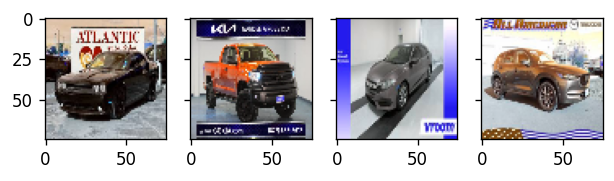

In [ ]:
#  Displaying random images
figure, axes = plt.subplots(1,4, dpi=120, sharey=True)
axes[0].imshow(dataset[2457][0])
axes[1].imshow(dataset[4756][0])
axes[2].imshow(dataset[23967][0])
axes[3].imshow(dataset[13929][0])

In [ ]:
#  defining splitting function
def train_val_split(dataset_to_split, val_pct):
  #  deriving dataset length
  number_of_instances = len(dataset_to_split)
  #  deriving length of validattion set
  val_idx = int(number_of_instances*val_pct)
  #  deriving random permutations of the whole dataset
  idx = list(np.random.permutation(number_of_instances))
  return idx[:val_idx], idx[val_idx:]

#  creating testing, validation and training indices
test_indices, dataset_indices = train_val_split(dataset, 0.1)
val_indices, train_indices = train_val_split(dataset_indices, 0.2)

#  splitting into training, validation and test sets
training_set = dataset[train_indices]
validation_set = dataset[val_indices]
test_set = dataset[test_indices]

In [ ]:
#  extending Dataset class
class VehicleDataset(Dataset):
  def __init__(self, loaded_dataset, transforms=None):
    self.loaded_dataset = loaded_dataset
    self.transforms = transforms

  def __len__(self):
    return len(self.loaded_dataset)
  
  def __getitem__(self, idx):
    #  extracting image from index and scaling
    image = self.loaded_dataset[idx][0]/255
    #  extracting label from index
    label = torch.tensor(int(self.loaded_dataset[idx][1]))
    #  applying transforms if transforms are supplied
    if self.transforms:
      image = self.transforms(image)
    return (image, label)

In [ ]:
#  creating an instances of the dataset class
train_ds = VehicleDataset(training_set, transforms=transforms.ToTensor())
val_ds = VehicleDataset(validation_set, transforms=transforms.ToTensor())
test_ds = VehicleDataset(test_set, transforms=transforms.ToTensor())

#  creating dataloaders
train_dl = DataLoader(train_ds, batch_size=100, shuffle=True) 
val_dl = DataLoader(val_ds, batch_size=100, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=100, shuffle=True)

In [ ]:
model = models.resnet50()
model.to(device)